# Using Python and kkcalc to calculate δ, β, and RSoXS binary contrast(s) from NEXAFS data

This notebook authored by Dean M. DeLongchamp of NIST<br>
with some parts based on elements of a repository from Daniel Schick: https://github.com/dschick/kkcalc<br>
with some parts based on further modifications by Kristof Toth of NIST<br>
## Introduction
The goal of this notebook is to demonstrate how to calculate the two components of the soft x-ray index of refraction β and δ, where: $n(E) = 1-δ(E) + iβ(E)$, and then to demonstrate how to calculate binary contrasts from these values. The narrative roughly follows the materials systems of Ferron et al. cited below, which includes polystyrene (PS), poly(methyl methacrylate) (PMMA), and vacuum (vac).<br><br>
For kkcalc reference:<br>
<a href="https://opg.optica.org/oe/fulltext.cfm?uri=oe-22-19-23628">Benjamin Watts "Calculation of the Kramers-Kronig transform of X-ray spectra by a piecewise Laurent polynomial method" Opt. Express 22, (2014) 23628-23639. DOI:10.1364/OE.22.023628 </a>
<br>
Pip page for kkcalc: https://pypi.org/project/kkcalc/ <br>
Benjamin Watts github: https://github.com/benajamin/kkcalc <br><br>
For RSoXS Contrast Calculation Reference: <br>
<a href="https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.167801">T Ferron, M Pope, BA Collins, "Spectral Analysis for Resonant Soft X-Ray Scattering Enables Measurement of Interfacial Width in 3D Organic Nanostructures." Phys. Rev. Lett. 2017, 119, 167801. DOI:10.1103/PhysRevLett.119.167801 </a>
<br>


In [1]:
import kkcalc #this is the only library that you might not already have.
from kkcalc import data
from kkcalc import kk
#n.b. the dependencies of kkcalc GUI often cause probllems with installing the library. 
#Try: 
# pip install --no-dependencies

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rc, gridspec

## Starting Point: NEXAFS Data

We typically start from experimentally collected NEXAFS. This can be collected by the individual, or downloaded from a database or repository. <br> 
We will use PS  and PMMA from NIST that should be provided as separate files with this notebook.<br>
The PS file name is ps_nist.txt<br>
The PMMA file name is pmma_nist.txt<br>
These files are the PS and PMMA NEXAFS that was previously published in <a href="https://pubs.acs.org/doi/full/10.1021/la062707q">TH Epps, DM DeLongchamp, MJ Fasolka, DA Fischer, EL Jablonski, "Substrate Surface Energy Dependent Morphology and Dewetting in an ABC Triblock Copolymer Film." Langmuir 2007, 23, 3355</a>.

First we will examine polystyrene. An electron yield NEXAFS spectrum of PS is provided in ps_nist.txt.

<div class="alert alert-block alert-info"><b>Tip:</b> The *.txt file is formatted with 1st column energy, second column intensity, tab-delimited. The cells below show one way to visualize this data, although such visualization isn't strictly necessary for the workflow shown here.
</div>

In [2]:
ps_energy, ps_pey= np.loadtxt('ps_nist.txt').T

#create xarray Dataset with the NEXAFS data:
ps_nexafs = xr.Dataset({'electron yield':(['energy'],ps_pey)},coords={'energy':ps_energy})
ps_nexafs.energy.attrs['unit'] = 'eV'
ps_nexafs['electron yield'].attrs['unit'] = 'a.u.'

In [3]:
#adjust the plot style to your liking or disable the style.use and rc calls if you prefer the defaults.

plt.style.use('dark_background')
font = {#'family' : 'sans-serif',
        'sans-serif' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 14}
rc('font', **font)
h_size = 10
v_size = 7

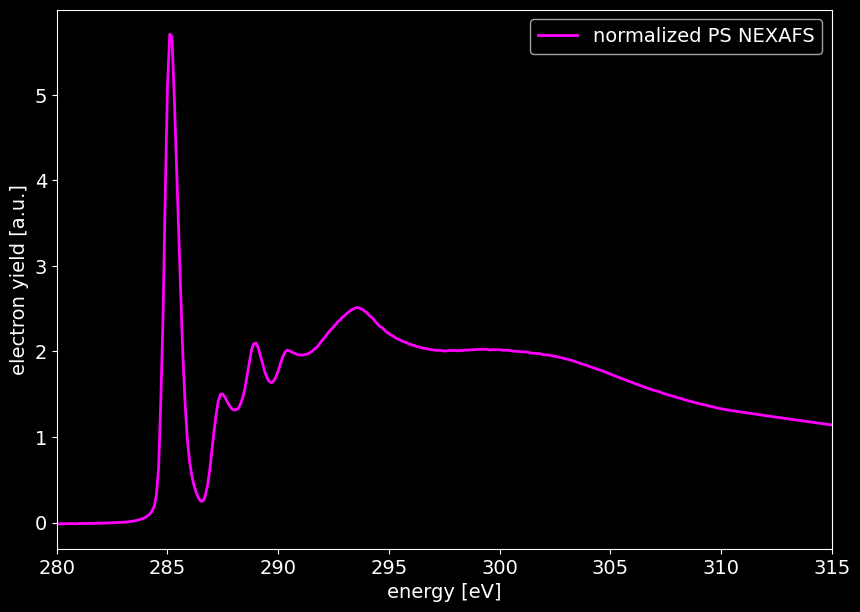

In [4]:
fig, ax1 = plt.subplots(figsize=(h_size, v_size))
#the xarray way of plotting
ps_nexafs['electron yield'].plot(ax=ax1, lw = 2, color='magenta', label='normalized PS NEXAFS')
ax1.set_xlim(280,315)
ax1.legend()
plt.show()
plt.close()

<div class="alert alert-block alert-info">
<b>Tip:</b> This NEXAFS has been pre- and post-edge normalized such that the pre-edge intensity is 0 and the post-edge intensity is 1. You should get similar results with kkcalc with data having only the pre-edge normalized.
</div>
<div class="alert alert-block alert-warning">
<b>Alternative approaches:</b> Other NEXAFS modes such as transmission or fluorescence yield are possible to use here. Alternatively, density functional theory calculations could also be used. Orientational P-RSoXS and P-RSoXR will use multiple NEXAFS curves at polarization extremes (e.g. s-polarized, and as close to p-polarized as can be approached), or NEXAFS that has been manipulated to exhibit "perfect" orientation with respect to a molecular reference frame, in either uniaxial or biaxial representations. These approaches will be covered in a future tutorial.
</div>

## Converting NEXAFS to β and δ for PS

### Running kkcalc

<div class="alert alert-block alert-info"><b>Tip:</b> This cell runs the kkcalc machinery. Be sure to adjust the chemical formula and density. It prefers input NEXAFS as a *.txt file with 1st column energy, second column intensity, tab-delimited. Nothing special has been done here to change the working directory, so be sure that the file is in the current working directory.
</div>

In [5]:
# Specify the minimum and maximum energy to fit to Henke database
x_min = 270
x_max = 325

chemical_formula = 'C8H8'
density = 1.05 # g/cc

# The output of kk.kk_calculate_real is f1 and f2 terms since they are calculated using Kramers-Kronig transform
output = kk.kk_calculate_real('ps_nist.txt',
                              chemical_formula,
                              load_options=None,
                              input_data_type='Beta',
                              merge_points=[x_min, x_max],
                              add_background=False,
                              fix_distortions=False,
                              curve_tolerance=0.05,
                              curve_recursion=100)

#From https://pypi.org/project/kkcalc/
    # add_background is for replacing the background (by extrapolating the pre-edge region) that may have been subtracted from the user-supplied data. This function has not been reimplemented to work with the internal data format currently used by KKcalc
        # it is possible that this option should always be set to False
    # fix_distortions option will skew the data to fit the slope of the scattering factor data. This is useful for working with data recorded using detectors with an uncalibrated energy dependence. 
        # we don't encourage the use of this option; it is better to manipulate your NEXAFS manually if necessary
    # if curve_tolerance is not None, kkcalc code will run an "improve_accuracy" code, where curve_tolerance and curve_recursion affects its behavior as follows:
        # tolerance : float Level of error in linear extrapolation of data values to be allowed.
        # recursion : integer Number of times an energy interval can be halved before giving up.
        # we find that enabling these features does not incur a major performanc penalty with the advantage of conferring greater accuracy
    
# Fitting to the Henke atomic scattering factors using the given stoichiometry and formula
stoichiometry = kk.data.ParseChemicalFormula(chemical_formula)
formula_mass = data.calculate_FormulaMass(stoichiometry)
ASF_E, ASF_Data = kk.data.calculate_asf(stoichiometry)
ASF_Data2 = kk.data.coeffs_to_ASF(ASF_E, np.vstack((ASF_Data, ASF_Data[-1])))

##Plot of f1 and f2 along with Henke f2 values
##enable these lines if you want to see the f1 and f2 components plus the bare atom
# plt.figure()
# plt.plot(output[:, 0], output[:, 1], label='f1 kkcalc')
# plt.plot(output[:, 0], output[:, 2], label='f2 kkcalc')
# plt.plot(ASF_E, ASF_Data2, label='Henke f2')
# plt.legend()
# plt.xlim(x_min, x_max)
# plt.title('{:d} eV - {:d} eV'.format(x_min, x_max),fontsize=16)
# plt.xlabel('Energy [eV]',fontsize=16)
# plt.ylabel('f1, f2',fontsize=16)
# plt.show()

kkcalc natively produces "scattering factors" f', f" (f1 and f2); these are just a differently transformed version of our target optical constants β, δ. The hard X-ray anomalous small-angle scattering (ASAXS) community prefers scattering factors f1, f2 (or f', f"), whereas the RSoXS community tends to use β, δ. The quantities are related by material-specific scaling factors:

***
$\mathbf{\text{Relations between  $f'$, $f''$ and $\delta$, $\beta$}}$<br>
$\delta = Kf'$<br>
$\beta = Kf''$<br>

$K = \displaystyle\frac{r_{e}\lambda^2}{2\pi}\frac{N_{A}}{A}\rho$<br>

where $\displaystyle\frac{N_{A}}{A}$ is the number of atoms per gram, $r_{e}$ is the classical electron radius in cm, $\lambda$ is the wavelength in cm, and $\rho$ is the density in grams per cm$^3$
***

For those interested in more information on ASAXS analysis approaches, we recommend <a href="https://www.tandfonline.com/doi/full/10.1080/14786430802279760">D Tatchev, "Structure analysis of multiphase systems by anomalous small-angle X-ray scattering." Philosophical Magazine 2008, 88, 1751. </a>

<div class="alert alert-block alert-info"><b>Tip:</b> Commented-out functions in the cell above will show the f1, f2 components and the bare atom; enabling these can be useful when troubleshooting kkcalc.
</div>

<div class="alert alert-block alert-info"><b>Tip:</b> kkcalc can fail if the NEXAFS has the pre-edge higher than the post-edge or other baseline anomalies. In those cases it will likely "flip" β so that the peaks become negative. If β gets flipped the results are incorrrect and should not be used. Good NEXAFS with beginning and ends that are roughly proportional to the bare-atom expectations is necessary for kkcalc to work. In principle, perfectly correct NEXAFS should have a baseline exactly identical to the bare atom.
</div>
<div class="alert alert-block alert-warning">
<b>Alternative approaches:</b> Other elemental edges also work with kkcalc; heteroatoms are already included in this calculation and a different energy range of input NEXAFS will produce N, O, S-edge, etc. In principle the KK is more accurate if you input a survey scan, that is a continuous scan across the relevant edges, but in practice that approach may exaggerate an erroneous slope compared to the bare atom. For these reasons, generally the community eschews adding fine structure significantly outside of the region of interest, even though it could in principle produce more accurate optical constants.</div>

### Conversion of f1 and f2 to β and δ

In [6]:
ps = xr.Dataset({
    'δ':(['energy'],data.convert_data(output[:,[0,1]],'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)[:,1]), 
    'β':(['energy'],data.convert_data(output[:,[0,2]],'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)[:,1])},
    coords={'energy': data.convert_data(output[:,[0,1]],'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)[:,0]})

ps.energy.attrs['unit'] = 'eV'
ps.δ.attrs['unit'] = 'a.u.'
ps.β.attrs['unit'] = 'a.u.'

### Plotting β and δ

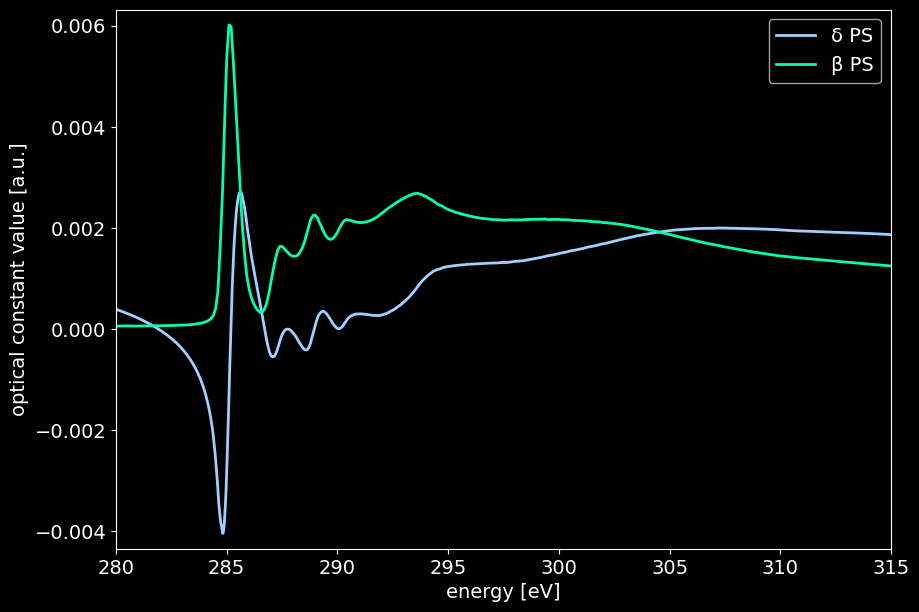

<function matplotlib.pyplot.close(fig=None)>

In [7]:
xmin = 280
xmax = 315
fig, ax1 = plt.subplots(figsize=(h_size, v_size))
ps.δ.plot(ax=ax1, color = 'xkcd:baby blue', lw = 2, label = 'δ PS')
ps.β.plot(ax=ax1, color = 'xkcd:bright sea green', lw = 2, label='β PS')
ax1.set_xlim(xmin,xmax)
ymin = min(ps.δ.sel(energy=slice(xmin,xmax)).min(), ps.β.sel(energy=slice(xmin,xmax)).min())
ymax = max(ps.δ.sel(energy=slice(xmin,xmax)).max(), ps.β.sel(energy=slice(xmin,xmax)).max())
ax1.set_ylim(ymin - (ymax-ymin)*0.03, ymax + (ymax-ymin)*0.03)
ax1.set_ylabel('optical constant value [a.u.]')
ax1.legend()
plt.show()
plt.close

Observations:
- δ and β are the two components of the soft x-ray index of refraction for polystyrene, where: $n(E) = 1-δ(E) + iβ(E)$
- δ and β are variously called "optical constants" or "dielectric function." Note they are scalars in this workup but they can be unaxial (two elements, "ordinary" and "extraordinary," or "perp," and "para"), or biaxial (three elements, xx,yy,zz)
- δ and β are unitless but the magnitude is meaningful; correct magnitude is required to compare material to material.<br>

<div class="alert alert-block alert-success">
<b>Important:</b> The δ and β results from this calculation are what you want to use to compose CyRSoXS "MaterialX.txt" dielectric functions. More details are given in CyRSoXS documentation for parsing these results into the CyRSoXS-compatible format, but they assume you have calculated smooth functions of δ and β as done here.
</div>
<div class="alert alert-block alert-info"><b>Tip:</b> β is a specially baselined and rescaled version of the NEXAFS absorbance; notice that it is offset slightly from zero in the pre-edge (<283 eV); this is close to the bare-atom absorbance at that energy. It is scaled in the post-edge to match the bare-atom absorbance at those energies. Essentially kkcalc takes the NEXAFS and "grafts" it onto the atomic cross section (which is devoid of peaks) by matching the NEXAFS and the bare atom absorbance at your specified min and max energy. δ is calculated from scratch using a piecewise Kramers-Kronig formalism enforcing consistency with beta. There are other calculation schemes for δ. QANT, for example uses a different algorithm that produces slightly different results. All KK calculations are approximate and vary based on the details of the numerical method used.
</div>

## PS:Vac contrast
We can already calculate one significant contrast: that of PS with vacuum:

In [8]:
ps_vac_contrast = np.power(ps.energy,4)*(np.power(ps.δ,2) + np.power(ps.β,2)) 
#notice this follows the math of Ferron at el cited at top. This formula is in the Fig 1b caption.

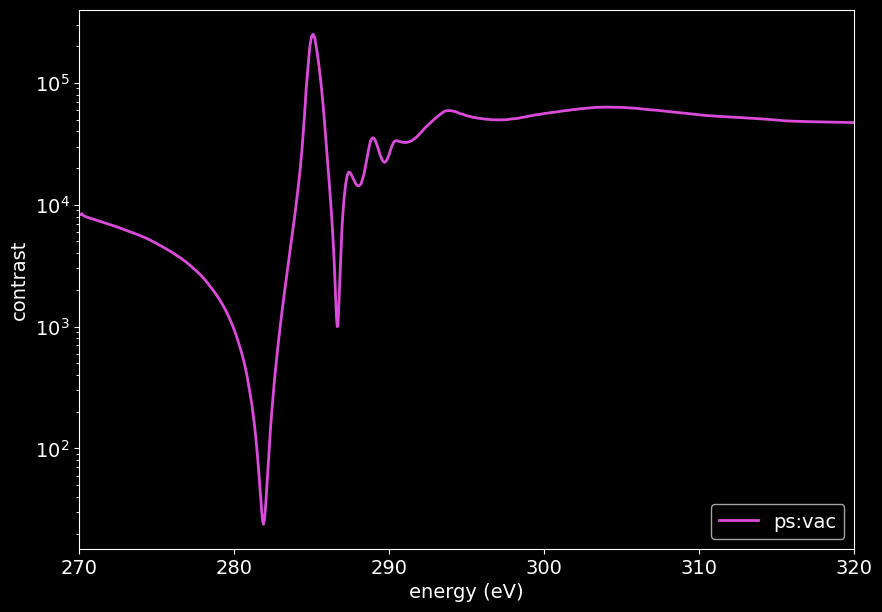

<function matplotlib.pyplot.close(fig=None)>

In [9]:
#plot the ps:vac contrast
xmin = 270
xmax = 320
fig, ax1 = plt.subplots(figsize=(h_size, v_size))
ps_vac_contrast.plot(ax=ax1, color = 'xkcd:pink purple', lw = 2, label='ps:vac')
ax1.set_xlim(xmin,xmax)
ax1.set_yscale('log')
ax1.set_ylabel('contrast')
ax1.set_xlabel('energy (eV)')
ax1.legend(loc='lower right')
plt.show()
plt.close

Observations:
- Notice the similarity of this contrast function to the Ferron et al Figure 1 b PS:Vac trace. It will look a little different because our PS NEXAFS was a little different than Ferron's.
- It is customary to plot contrast on a y log scale.
- Units on contrast are not especially meaningful.<br><br>
<div class="alert alert-block alert-info">
<b>Tip:</b> There are discussions across the RSoXS community about how variations in NEXAFS (particularly the ratio of peak intensities to post edge intensities, and the post-edge decay slope) are common due to different electron yield detection schemes but these differences are artifacts and there is only one correct underlying dielectric function. At some point, however, you have to trust your data! 
</div>
<div class="alert alert-block alert-info">
<b>Tip:</b> Another thing to look out for is energy miscalibration betweeen your reference NEXAFS spectra and your RSoXS data. Sometimes you have to shift one or the other to get them to agree. Note that the contrast function contains features that are extremely narrow in energy, that would require nearly perfect agreement in energy calibration to fit.
</div>

### Wrapping in functions

For future uses we will wrap the calculation machinery in a function:

In [10]:
def run_kkcalc(nexafs_file, x_min = 270, x_max = 325, chemical_formula = 'CH2', density = 1.00):
    # The output of kk.kk_calculate_real is f1 and f2 terms since they are calculated using Kramers-Kronig transform
    output = kk.kk_calculate_real(nexafs_file,
                                  chemical_formula,
                                  load_options=None,
                                  input_data_type='Beta',
                                  merge_points=[x_min, x_max],
                                  add_background=False,
                                  fix_distortions=False,
                                  curve_tolerance=0.05,
                                  curve_recursion=100)

    # Fitting to the Henke atomic scattering factors using the given stoichiometry and formula
    stoichiometry = kk.data.ParseChemicalFormula(chemical_formula)
    formula_mass = data.calculate_FormulaMass(stoichiometry)
    ASF_E, ASF_Data = kk.data.calculate_asf(stoichiometry)
    ASF_Data2 = kk.data.coeffs_to_ASF(ASF_E, np.vstack((ASF_Data, ASF_Data[-1])))
    # Conversion to delta and beta and making an xarray
    n = xr.Dataset({
        'δ':(['energy'],data.convert_data(output[:,[0,1]],'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)[:,1]), 
        'β':(['energy'],data.convert_data(output[:,[0,2]],'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)[:,1])},
        coords={'energy': data.convert_data(output[:,[0,1]],'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)[:,0]})

    n.energy.attrs['unit'] = 'eV'
    n.δ.attrs['unit'] = 'a.u.'
    n.β.attrs['unit'] = 'a.u.'
    
    return n #return an xarray

A function to calculate binary contrasts:

In [11]:
#notice this follows the math of Ferron at el cited at top. This formula is in the Fig 1b caption.
#this will accept and return xarrays
def binary_contrast(n1, n2=None):
    if n2 is None:
        #second component is vacuum
        n2 = xr.zeros_like(n1)
    else:
        #second is interpolated to match the energy array of the first component.  
        n2 = n2.interp(energy=n1.energy)
    return n1.energy**4 * ((n1.δ-n2.δ)**2 + (n1.β-n2.β)**2)

## PMMA δ and β
Run the same set of calculations for PMMA:

In [12]:
pmma = run_kkcalc('pmma_nist.txt', x_min = 270, x_max = 325, chemical_formula = 'C5O2H8', density = 1.18)

/tmp/ipykernel_727792/1530841187.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0, 0])


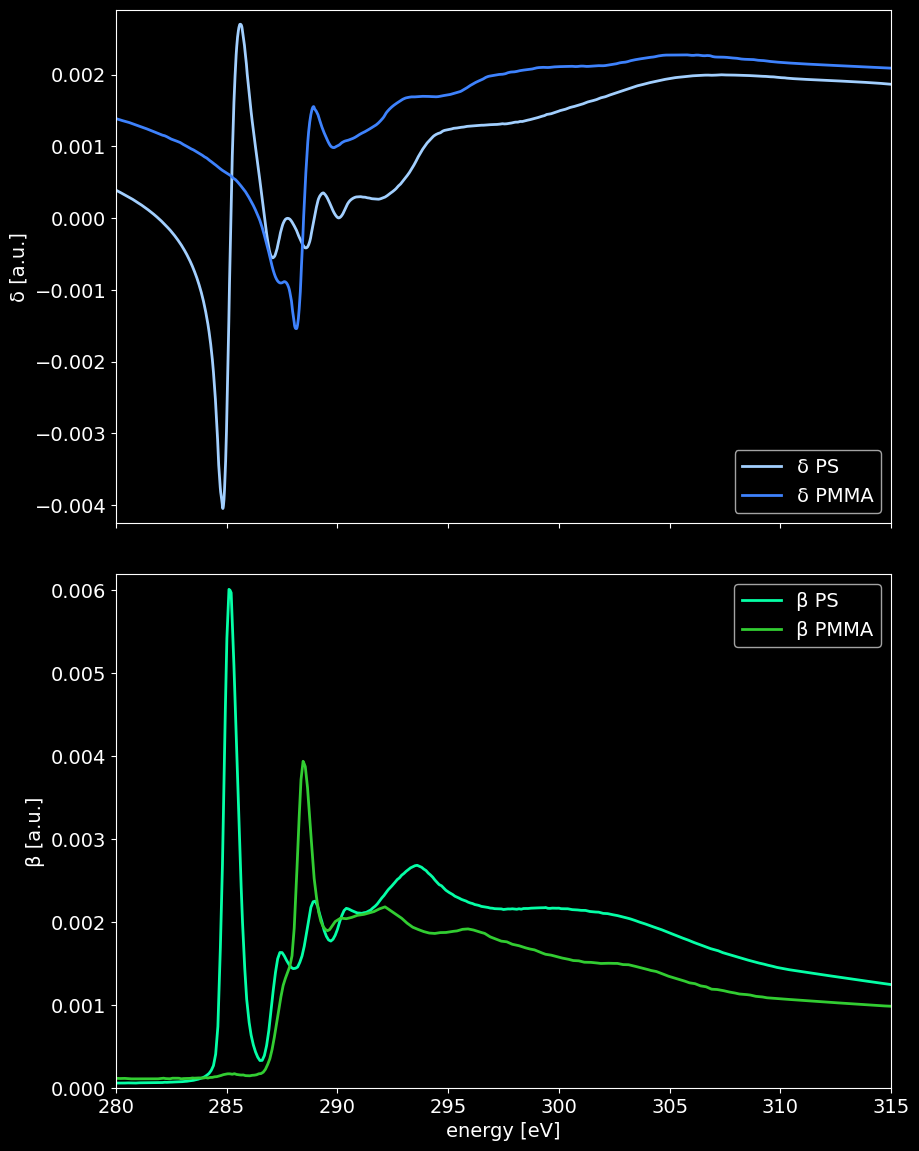

<function matplotlib.pyplot.close(fig=None)>

In [13]:
#plot the PMMA  δ and β
xmin = 280
xmax = 315
fig, ax = plt.subplots(figsize=(h_size, v_size*2))
gs = gridspec.GridSpec(nrows=2, 
                   ncols=1, 
                   figure=fig,
                   width_ratios= [1],
                   height_ratios=[1, 1],
                   wspace=0.05,
                   hspace=0.1)

ax1 = plt.subplot(gs[0, 0])
#xarray way of adding to a plot
ps.δ.plot(ax =ax1, color = 'xkcd:baby blue', lw = 2, label = 'δ PS')
pmma.δ.plot(ax =ax1, color = 'xkcd:dodger blue', lw = 2, label = 'δ PMMA')
ymin1 = min(ps.δ.sel(energy=slice(xmin,xmax)).min(), pmma.δ.sel(energy=slice(xmin,xmax)).min())
ymax1 = max(ps.δ.sel(energy=slice(xmin,xmax)).max(), pmma.δ.sel(energy=slice(xmin,xmax)).max())
ax1.set_xlim(xmin, xmax)
ax1.set_xlabel('')
ax1.set_ylim(ymin1 - (ymax1-ymin1)*0.03, ymax1 + (ymax1-ymin1)*0.03)
ax1.legend(loc ='lower right')
ymax2 = max(ps.β.sel(energy=slice(xmin,xmax)).max(), pmma.β.sel(energy=slice(xmin,xmax)).max())
ax2 = plt.subplot(gs[1, 0], sharex = ax1)
ps.β.plot(ax =ax2, color = 'xkcd:bright sea green', lw = 2, label = 'β PS')
pmma.β.plot(ax =ax2, color = 'limegreen', lw = 2, label = 'β PMMA')
ax2.legend(loc='upper right')
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(0, ymax2 + (ymax2)*0.03)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.show()
plt.close

## Remaining contrasts:

Now we can calculate the rest of the binary contrast functions in the system.
<div class="alert alert-block alert-info">
<b>Tip:</b> For a system of N components (be sure to include vacuum!), there will be N(N-1)/2 binary contrasts. In the PS:PMMA:vac system, 3(3-1)/2 = 3.
</div>

In [14]:
pmma_vac_contrast = binary_contrast(pmma)
ps_pmma_contrast =  binary_contrast(ps, pmma)

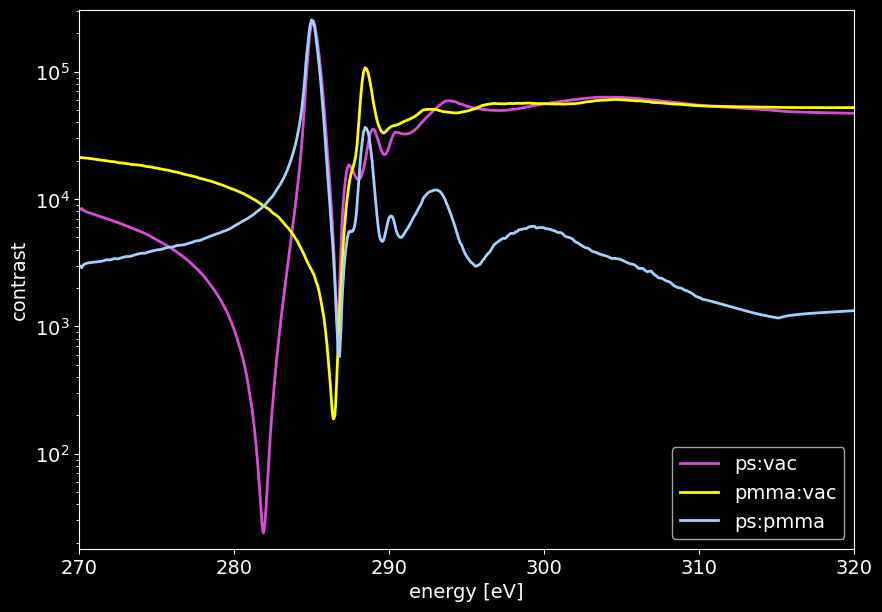

<function matplotlib.pyplot.close(fig=None)>

In [15]:
#plot the remaining contrasts
xmin = 270
xmax = 320
fig, ax1 = plt.subplots(figsize=(h_size, v_size))
#xarray way of adding to a plot
ps_vac_contrast.plot(ax=ax1, color = 'xkcd:pink purple', lw = 2, label='ps:vac')
pmma_vac_contrast.plot(ax=ax1, color = 'yellow', lw = 2, label='pmma:vac')
ps_pmma_contrast.plot(ax=ax1, color = 'xkcd:baby blue', lw = 2, label='ps:pmma')
ax1.set_xlim(xmin, xmax)
ymin = min(ps_vac_contrast.sel(energy=slice(xmin,xmax)).min(), pmma_vac_contrast.sel(energy=slice(xmin,xmax)).min(), ps_pmma_contrast.sel(energy=slice(xmin,xmax)).min())
ymax = max(ps_vac_contrast.sel(energy=slice(xmin,xmax)).max(), pmma_vac_contrast.sel(energy=slice(xmin,xmax)).max(), ps_pmma_contrast.sel(energy=slice(xmin,xmax)).max())
ax1.set_ylim(ymin*0.75,ymax*1.2)
ax1.set_yscale('log')
ax1.set_ylabel('contrast')
ax1.legend(loc='lower right')
plt.show()
plt.close

Observations:
- Note the similiarity of the plot above with Ferron et al. Figure 1b. 
- Small differences are due to the use of different NEXAFS data as discussed above. <br><br>

<div class="alert alert-block alert-success">
<b>Important:</b> The binary contrast functions show you how you should expect total scattering intensity (TSI) or "invariant" in RSoXS to vary with energy. Because the contrast units are meaningless, there should be a scaling factor between this calculated contrast and the measured TSI. In a two-component system, it should be exactly proportional. We emphasize Ferron et al. because it is the first RSoXS paper to demonstrate this proportionality quantitatively. 
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> In a system with more than two components, the pairwise binary contrast functions must be combined with volume fraction information to yield an expectation of how the whole sample TSI should behave with energy.  All of the binary contrasts are operative in RSoXS, all the time. To isolate one component or pair from the others is very challenging, but the binary contrasts give us a guide. More conceptual information about the invariant is provided on the <a href="https://www.sasview.org/docs/user/qtgui/Perspectives/Invariant/invariant_help.html">SASView webpage </a> but be aware that for conventional SAXS and SANS energy dependence will not be discussed.
</div>
<div class="alert alert-block alert-info">
<b>Tip:</b> Note that vacuum contrast is typically higher than composition contrast for most energies. This is why <em><b>sample roughness</em></b> cannot be ignored in RSoXS. Roughness and porosity will produce vacuum contrast, and vacuum contrast can dominate even for fairly smooth films because the films will be <em>thin</em>. For example, for a sample with 4 nm peak-to-valley thickness fluctuations on a 40 nm thick film at an energy where vacuum contrast is 10x greater than composition contrast, the vacuum contrast can contribute more than half of the contrast in the sample.
</div>
<div class="alert alert-block alert-warning">
<b>Alternative approaches:</b> For orientation-sensitive approaches, one would calculate δ and β for each part of the tensor from separate NEXAFS, meaning extraordinary and ordinary for uniaxial or xx, yy, zz for biaxial. Which NEXAFS one chooses for these parts of the tensor will affect what the dielectric function represents. These ideas will be covered more thoroughly in a later tutorial.
</div><br>


## Bonus: comparison with optical constants from a database
A small database of soft X-ray optical constants is provided in <a href="https://github.com/EliotGann/Optical-Constants-Database">Eliot Gann's github</a>.<br><br>
Here we download some of those constants directly from github into your working directory:

In [16]:
import requests
with open('ps.oc', 'wb') as f:
    f.write(requests.get('http://github.com/EliotGann/Optical-Constants-Database/raw/master/Optical Constants/ps.oc').content)
with open('pmma.oc', 'wb') as f:
    f.write(requests.get('http://github.com/EliotGann/Optical-Constants-Database/raw/master/Optical Constants/pmma.oc').content)

Eliot uses HD5 format to pack these so we must use h5py to read them: 

In [17]:
import h5py
f_ps = h5py.File('ps.oc', 'r')
f_pmma = h5py.File('pmma.oc', 'r')

Exploring hd5 records is enhanced with a little helper function:

In [18]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))

In [19]:
f_ps.visititems(print_attrs)

entry
    NX_class: NXentry
    default: dielectric_function
entry/dielectric_function
    NX_class: NXdata
    beta_axes: energy,orientation
    database_accept_hash: untracked
    database_name: NIST Optical Constants DB
    delta_axes: energy,orientation
    signal: delta,beta
entry/dielectric_function/beta
    long_name: delta
    units: 
entry/dielectric_function/delta
    long_name: delta
    units: 
entry/dielectric_function/energy
    long_name: Energy [Ev]
    units: electronvolt
entry/dielectric_function/orientation_vector
    orientation_details: isotropic
    orientation_type: isotropic
entry/optical_constants_origin
    corresponding_author: Eliot Gann
    corresponding_author_email: eliot.gann@nist.gov
    publication_doi: N/A
    submitter: Eliot Gann
    submitter_email: eliot.gann@nist.gov
    time: 3672736800.0
entry/optical_constants_origin/type
    facility: NSLS-II
    instrument: SST-1 RSoXS
    normalization_method: projected based on atomic spectra
    technique

<div class="alert alert-block alert-info">
<b>Tip:</b>  Note that most of these keys refer to helpful metadata. The <b>entry/dielectric_function/...</b> series has the info we need.
</div>

In [20]:
#wrap these database values in xarrays
ps_db = xr.Dataset({
    'δ':(['energy'],f_ps['entry/dielectric_function/delta']), 
    'β':(['energy'],f_ps['entry/dielectric_function/beta'])},
    coords={'energy': f_ps['entry/dielectric_function/energy']})
ps_db.energy.attrs['unit'] = 'eV'
ps_db.δ.attrs['unit'] = 'a.u.'
ps_db.β.attrs['unit'] = 'a.u.'
f_ps.close()

pmma_db = xr.Dataset({
    'δ':(['energy'],f_pmma['entry/dielectric_function/delta']), 
    'β':(['energy'],f_pmma['entry/dielectric_function/beta'])},
    coords={'energy': f_pmma['entry/dielectric_function/energy']})
pmma_db.energy.attrs['unit'] = 'eV'
pmma_db.δ.attrs['unit'] = 'a.u.'
pmma_db.β.attrs['unit'] = 'a.u.'
f_pmma.close()

Plot the optical constants from the database vs. the ones that we made in kkcalc

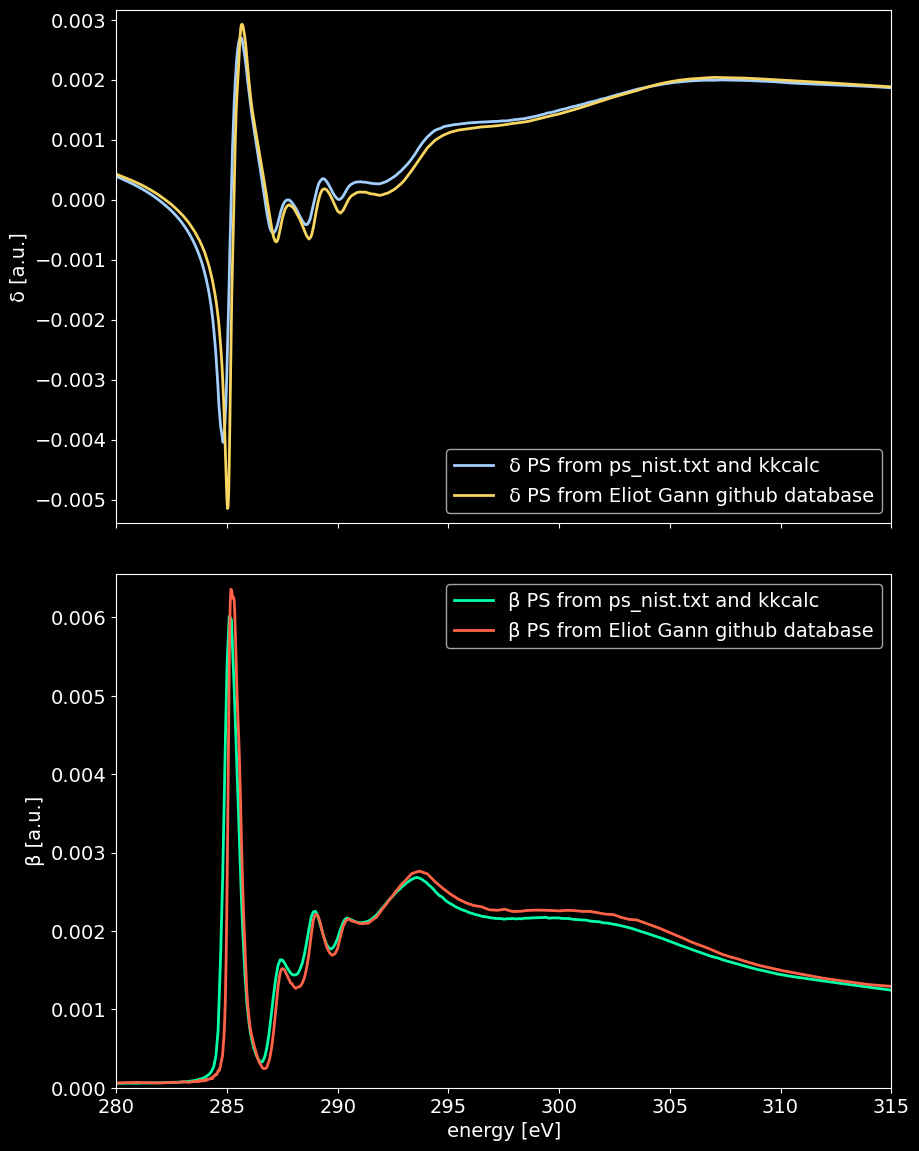

<function matplotlib.pyplot.close(fig=None)>

In [21]:
xmin = 280
xmax = 315

fig, ax = plt.subplots(figsize=(h_size, v_size*2))

gs = gridspec.GridSpec(nrows=2, 
                   ncols=1, 
                   figure=fig,
                   width_ratios= [1],
                   height_ratios=[1, 1],
                   wspace=0.05,
                   hspace=0.1)

ax1 = plt.subplot(gs[0, 0])

ps.δ.plot(ax =ax1, color = 'xkcd:baby blue', lw = 2, label = 'δ PS from ps_nist.txt and kkcalc')
ps_db.δ.plot(ax=ax1, color = 'xkcd:light mustard', lw = 2, label = 'δ PS from Eliot Gann github database')

ymin1 = min(ps.δ.sel(energy=slice(xmin,xmax)).min(), ps_db.δ.sel(energy=slice(xmin,xmax)).min())
ymax1 = max(ps.δ.sel(energy=slice(xmin,xmax)).max(), ps_db.δ.sel(energy=slice(xmin,xmax)).max())

ax1.set_xlim(xmin,xmax)
ax1.set_xlabel('')
ax1.set_ylim(ymin1-(ymax1-ymin1)*0.03,ymax1 + (ymax1-ymin1)*0.03)
ax1.legend(loc ='lower right')

ax2 = plt.subplot(gs[1, 0], sharex = ax1)
ps.β.plot(ax =ax2, color = 'xkcd:bright sea green', lw = 2, label = 'β PS from ps_nist.txt and kkcalc')
ps_db.β.plot(ax=ax2, color = 'tomato', lw = 2, label = 'β PS from Eliot Gann github database')

ymax2 = max(ps.β.sel(energy=slice(xmin,xmax)).max(), ps_db.β.sel(energy=slice(xmin,xmax)).max())

ax2.legend(loc='upper right')
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(0, ymax2*1.03)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.show()
plt.close

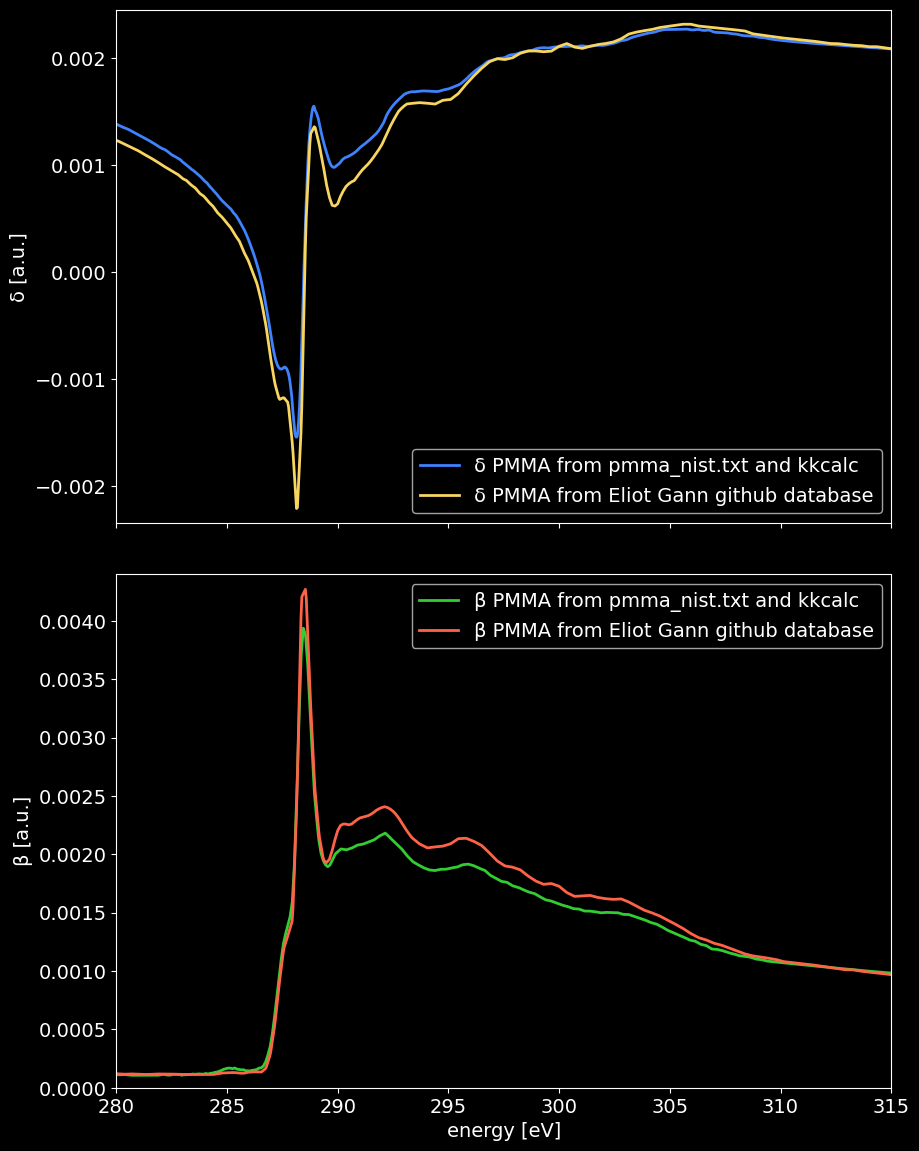

<function matplotlib.pyplot.close(fig=None)>

In [22]:
fig, ax = plt.subplots(figsize=(h_size, v_size*2))

gs = gridspec.GridSpec(nrows=2, 
                   ncols=1, 
                   figure=fig,
                   width_ratios= [1],
                   height_ratios=[1, 1],
                   wspace=0.05,
                   hspace=0.1)

ax1 = plt.subplot(gs[0, 0])
pmma.δ.plot(ax =ax1, color = 'xkcd:dodger blue', lw = 2, label = 'δ PMMA from pmma_nist.txt and kkcalc')
pmma_db.δ.plot(ax=ax1, color = 'xkcd:light mustard', lw = 2, label = 'δ PMMA from Eliot Gann github database')

ymin1 = min(pmma.δ.sel(energy=slice(xmin,xmax)).min(), pmma_db.δ.sel(energy=slice(xmin,xmax)).min())
ymax1 = max(pmma.δ.sel(energy=slice(xmin,xmax)).max(), pmma_db.δ.sel(energy=slice(xmin,xmax)).max())

ax1.set_xlim(xmin,xmax)
ax1.set_xlabel('')

ax1.set_ylim(ymin1 - (ymax1-ymin1)*0.03, ymax1 + (ymax1-ymin1)*0.03)
ax1.legend(loc ='lower right')

ax2 = plt.subplot(gs[1, 0], sharex = ax1)
pmma.β.plot(ax =ax2, color = 'limegreen', lw = 2, label = 'β PMMA from pmma_nist.txt and kkcalc')
pmma_db.β.plot(ax=ax2, color = 'tomato', lw = 2, label = 'β PMMA from Eliot Gann github database')

ymax2 = max(pmma.β.sel(energy=slice(xmin,xmax)).max(), pmma_db.β.sel(energy=slice(xmin,xmax)).max())

ax2.legend(loc='upper right')
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(0, ymax2*1.03)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.show()
plt.close

Reasonably good agreement among all datasets. Differences are due to subtle differences in NEXAFS collection conditions, and due to differences in kkcalc vs. QANT KK numerical routines.